In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import pandas as pd
from dotenv import load_dotenv
import numpy as np

import statsmodels.api as sm

from tqdm import tqdm
from pathlib import Path


import os
import sys

current_path = sys.path[0]
sys.path.append(current_path[: current_path.find("defi-measurement")] + "liquidity-distribution-history")

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# Adjust so all columns in dataframe are shown
pd.set_option("display.max_columns", None)

In [17]:
postgres_uri = os.environ["POSTGRESQL_URI"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

plot_base_path = Path(
    "/Users/larsankile/Dropbox/Apps/Overleaf/Robust Detection of Extractive Attacks in Decentralized Exchanges/Figures"
)

## Get data


In [8]:
count: int = int(
    pd.read_sql_query(
        """
    SELECT
        COUNT(*) as cnt
    FROM
        block_pool_metrics
    """,
        postgres_uri,
        dtype={"cnt": int},
    )
    .iloc[0]
    .cnt
)

f"Total number of rows: {count:,}"

'Total number of rows: 6,864,029'

In [9]:
chunksize = 100_000


dfs = pd.read_sql_query(
    """
    SELECT
        *
    FROM
        block_pool_metrics
    """,
    postgres_uri,
    chunksize=chunksize,
)

df = next(dfs)

for chunk in tqdm(dfs, total=count // chunksize):
    df = pd.concat([df, chunk])

100%|██████████| 68/68 [02:47<00:00,  2.46s/it]


In [10]:
df.head()

,block_number,pool_address,num_transactions,n_buys,n_sells,baseline_price,created_at,mev_boost,mev_boost_amount,realized_order,realized_prices,realized_l1,realized_l2,realized_linf,volume_heur_order,volume_heur_prices,volume_heur_l1,volume_heur_l2,volume_heur_linf,tstar_l1,tstar_l2,tstar_linf
0,15569292,0x0002e63328169d7feea121f1e32e4f620abf0352,1,0,1,0.326732,2023-08-23 19:47:19.321803,True,0.066007,[245_466],[0.31208738888205845],0.014645,0.014645,0.014645,[245_466],[0.31208738888205845],0.014645,0.014645,0.014645,0.014645,0.014645,0.014645
1,15577763,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.329891,2023-08-23 19:47:19.361765,True,0.104729,[199_418],[0.341110738723612],0.011220,0.011220,0.011220,[199_418],[0.341110738723612],0.011220,0.011220,0.011220,0.011220,0.011220,0.011220
2,15592175,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.341082,2023-08-23 19:47:19.407144,True,0.212331,[223_451],[0.35208506058056044],0.011003,0.011003,0.011003,[223_451],[0.35208506058056044],0.011003,0.011003,0.011003,0.011003,0.011003,0.011003
3,15813213,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.352052,2023-08-23 19:47:19.443550,True,0.071058,[247_609],[0.3683540249950845],0.016302,0.016302,0.016302,[247_609],[0.3683540249950845],0.016302,0.016302,0.016302,0.016302,0.016302,0.016302
4,15935551,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.352343,2023-08-23 19:47:19.490107,True,0.120780,[036_078],[0.4098137829269887],0.057471,0.057471,0.057471,[036_078],[0.4098137829269887],0.057471,0.057471,0.057471,0.057471,0.057471,0.057471


## Descriptive statistics


### Number of swaps in each pool-block pair


In [11]:
count_df = df.groupby("num_transactions").block_number.count().sort_index()
count_df = count_df[count_df.index < 50]
counts: np.ndarray = count_df.to_numpy()
index = count_df.index.to_numpy()

print(counts)
print(index)

[6075363  571623  151766   39511   13384    5663    2640    1366     849
     531     381     249     156     120     105      71      54      24
      30      21      20      11       4      11       8       5       5
       4       8       8       4       7       4       3       2       1
       4       1       1       1       1       2       1]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 42 43 44 47]


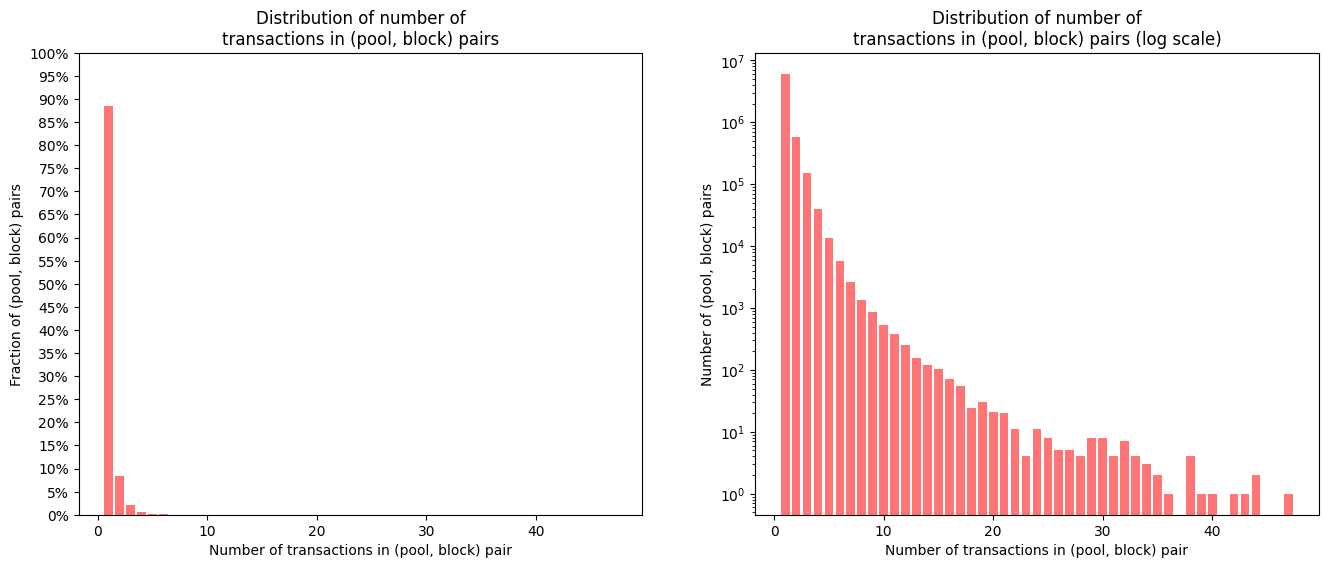

In [12]:
normalized = counts / counts.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_col = "#FF7474"

ax1.bar(index, normalized, color=bar_col)
ax1.set_xlabel("Number of transactions in (pool, block) pair")
ax1.set_ylabel("Fraction of (pool, block) pairs")
ax1.set_title("Distribution of number of\ntransactions in (pool, block) pairs")
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax1.set_yticks(np.arange(0, 1.05, 0.05))

ax2.bar(index, counts, color=bar_col)
ax2.set_yscale("log")
ax2.set_xlabel("Number of transactions in (pool, block) pair")
ax2.set_ylabel("Number of (pool, block) pairs")
ax2.set_title("Distribution of number of\ntransactions in (pool, block) pairs (log scale)")

### Number of blocks, min and max block number, total number of swaps, and total number of pools


In [21]:
print(f"There are {len(df)} (pool, block) pairs in the database")
print(f"There are {df.block_number.nunique():,} unique blocks in the database")
print(f"First block: {df.block_number.min():,}, last block: {df.block_number.max():,}")
print(f"Total number of transactions: {df.num_transactions.sum():,}")
print(f"There are {df.pool_address.nunique():,} unique pools in the database")

There are 6864029 (pool, block) pairs in the database
There are 1,866,537 unique blocks in the database
First block: 15,537,940, last block: 17,864,015
Total number of transactions: 7,994,736
There are 6,292 unique pools in the database


### Share of blocks, swaps, and pools created through MEV-boost auctions


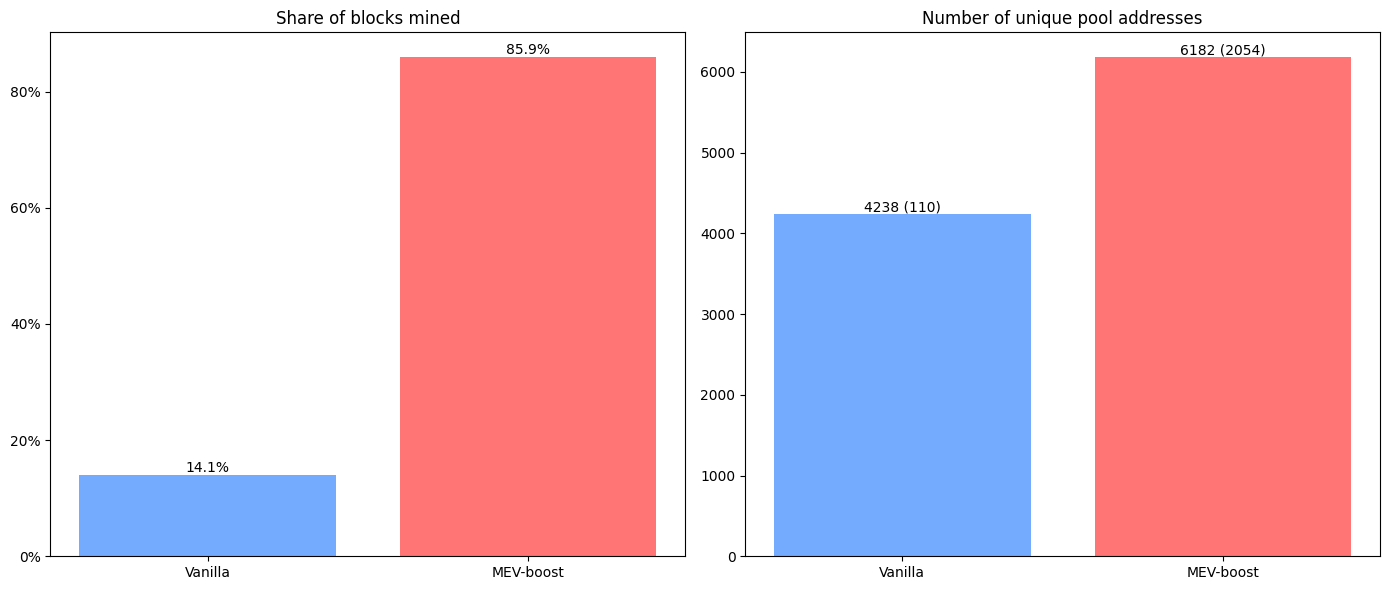

In [19]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
bar_cols = ["#74ABFF", "#FF7474", "#F3DAFF"]

# First plot
block_share = df.groupby("mev_boost").block_number.nunique().sort_index()
bars = ax1.bar(["Vanilla", "MEV-boost"], block_share.values / block_share.sum(), color=bar_cols)
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

ax1.set_title("Share of blocks mined")

# Second plot
pool_count = df.groupby("mev_boost").pool_address.nunique().sort_index()
bars = ax2.bar(["Vanilla", "MEV-boost"], pool_count.values, color=bar_cols)

only_vanilla = set(df[df.mev_boost == False].pool_address.unique())
only_mev = set(df[df.mev_boost == True].pool_address.unique())
only_vanilla_count = len(only_vanilla - only_mev)
only_mev_count = len(only_mev - only_vanilla)

# Add the values atop the bars
for bar, only in zip(bars, [only_vanilla_count, only_mev_count]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f"{height} ({only})", ha="center", va="bottom")

ax2.set_title("Number of unique pool addresses")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "descriptive" / "blocks_mined.pdf"))

In [21]:
def get_p_value(sums, counts):
    # Assuming group1 and group2 are the two groups with binary values (0 or 1)
    count1 = sums.loc[False]
    count2 = sums.loc[True]
    n1 = counts.loc[False]
    n2 = counts.loc[True]

    _, p_value = sm.stats.proportions_ztest([count1, count2], [n1, n2])

    return p_value

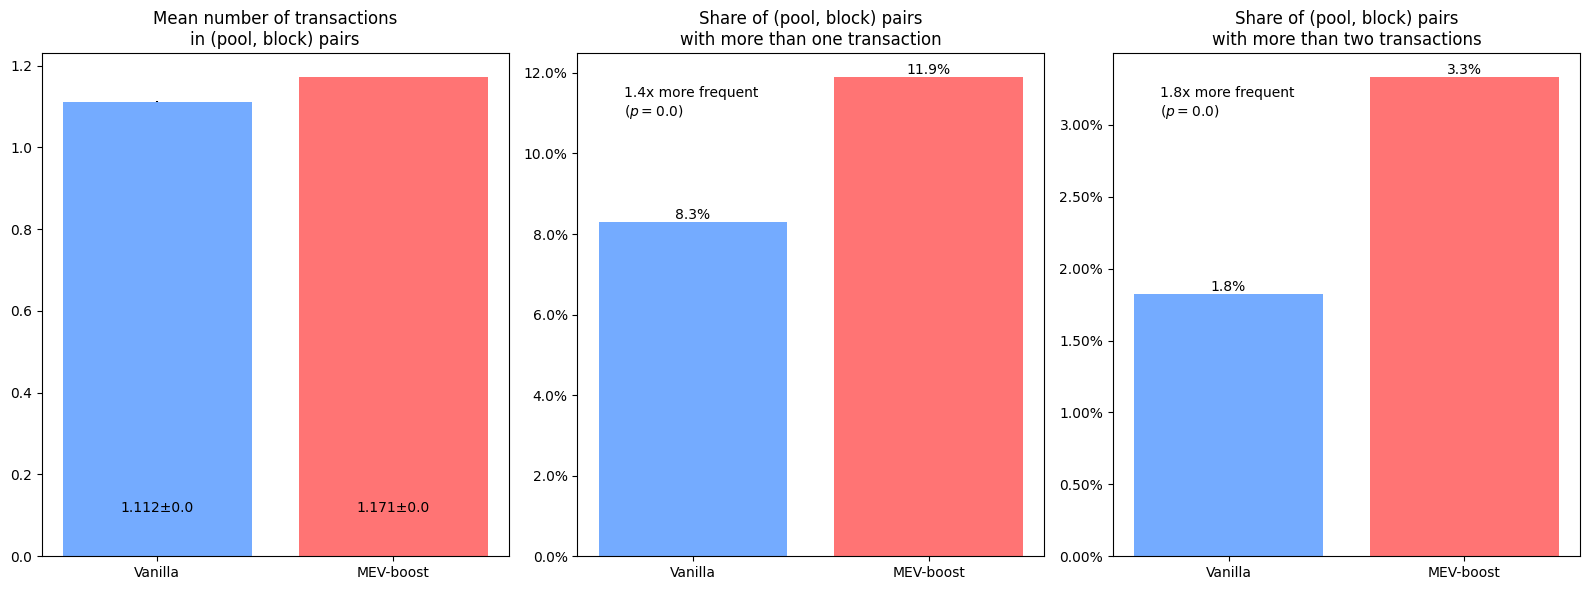

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# First plot
n_transaction_mean = df.groupby("mev_boost").num_transactions.mean().sort_index()
n_transaction_std = df.groupby("mev_boost").num_transactions.std().sort_index()
n_transaction_sem = df.groupby("mev_boost").num_transactions.sem().sort_index()

bars = ax1.bar(["Vanilla", "MEV-boost"], n_transaction_mean.values, color=bar_cols, yerr=n_transaction_sem.values)

# Add the values at the base of the bars
for bar, mean, std in zip(bars, n_transaction_mean.values, n_transaction_sem.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, 0.1, f"{mean:.3f}±{std:.1f}", ha="center", va="bottom")

ax1.set_title("Mean number of transactions\nin (pool, block) pairs")

# Second plot
share_more_than_one_mean = (
    df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.mean().sort_index()
)
sum_more_than_one = (
    df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.sum().sort_index()
)
count_more_than_one = (
    df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.count().sort_index()
)
p_value = get_p_value(sum_more_than_one, count_more_than_one)

bars = ax2.bar(["Vanilla", "MEV-boost"], share_more_than_one_mean.values, color=bar_cols)
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

ax2.set_title("Share of (pool, block) pairs\nwith more than one transaction")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_one_mean.values[1] / share_more_than_one_mean.values[0]
ax2.text(
    0.1, 0.9, f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)", ha="left", va="center", transform=ax2.transAxes
)

# Third plot
share_more_than_two_mean = (
    df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.mean().sort_index()
)
sum_more_than_two = (
    df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.sum().sort_index()
)
count_more_than_two = (
    df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.count().sort_index()
)
p_value = get_p_value(sum_more_than_two, count_more_than_two)

bars = ax3.bar(["Vanilla", "MEV-boost"], share_more_than_two_mean.values, color=bar_cols)
ax3.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

ax3.set_title("Share of (pool, block) pairs\nwith more than two transactions")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_two_mean.values[1] / share_more_than_two_mean.values[0]
ax3.text(
    0.1, 0.9, f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)", ha="left", va="center", transform=ax3.transAxes
)

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "descriptive" / "transactions_per_block.pdf"))

In [23]:
from scipy.stats import ttest_ind

# Split the data into two groups based on MEV-boost (true/false)
group1 = df[df["mev_boost"] == True]["num_transactions"]
group2 = df[df["mev_boost"] == False]["num_transactions"]

# Perform the two-sample t-test
t_stat, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 86.5151044369731
P-value: 0.0


## Statistics on the Metric


In [26]:
df_metric = df[df.num_transactions > 1]


df_metric = df_metric.assign(
    metric_l1=df_metric.realized_l1 / df_metric.volume_heur_l1,
    metric_l2=df_metric.realized_l2 / df_metric.volume_heur_l2,
    metric_linf=df_metric.realized_linf / df_metric.volume_heur_linf,
)

# Take out extreme outliers
outlier_thresh = 1e3
cnt_before = len(df_metric)
df_metric = df_metric[(df_metric.metric_l1 < outlier_thresh) & ((df_metric.metric_l1 > 1 / outlier_thresh))]
cnt_after = len(df_metric)
print(f"Removed {cnt_before - cnt_after} outliers ({(cnt_before - cnt_after) / cnt_before:.3%})")

df_metric_2 = df_metric[df_metric.num_transactions > 2]

df_metric_2 = df_metric_2.assign(
    metric_l1=df_metric_2.realized_l1 / df_metric_2.volume_heur_l1,
    metric_l2=df_metric_2.realized_l2 / df_metric_2.volume_heur_l2,
    metric_linf=df_metric_2.realized_linf / df_metric_2.volume_heur_linf,
)

df_metric.head()

Removed 149 outliers (0.019%)


,block_number,pool_address,num_transactions,n_buys,n_sells,baseline_price,created_at,mev_boost,mev_boost_amount,realized_order,realized_prices,realized_l1,realized_l2,realized_linf,volume_heur_order,volume_heur_prices,volume_heur_l1,volume_heur_l2,volume_heur_linf,tstar_l1,tstar_l2,tstar_linf,metric_l1,metric_l2,metric_linf
55,17322889,0x0c276bd9809a1192b6c5fa2e25e13555ed9b2e81,3,1,2,8.613061e+11,2023-08-23 19:47:21.643726,True,0.250871,"[001_014, 006_043, 008_058]","[840829940278.8574, 721513297880.2491, 7402227...",2.813524e+11,1.860712e+11,1.397928e+11,"[008_058, 001_014, 006_043]","[881772585213.9188, 860710508383.8119, 7372823...",1.450858e+11,1.257025e+11,1.240237e+11,1.444250e+11,1.254119e+11,1.235563e+11,1.939214,1.480251,1.127146
104,17326896,0x0c276bd9809a1192b6c5fa2e25e13555ed9b2e81,2,1,1,1.034087e+12,2023-08-23 19:47:22.394485,True,0.069571,"[004_031, 005_038]","[1098226588788.1937, 1088197064317.7977]",1.182505e+11,8.391597e+10,6.414003e+10,"[005_038, 004_031]","[1024920856402.6915, 1088657611047.4844]",6.373675e+10,5.533543e+10,5.457105e+10,6.373675e+10,5.533543e+10,5.457105e+10,1.855296,1.516496,1.175349
107,17326968,0x0c276bd9809a1192b6c5fa2e25e13555ed9b2e81,2,0,2,1.159106e+12,2023-08-23 19:47:22.582374,True,0.055637,"[004_009, 005_013]","[1135340168304.3743, 1058018128558.1155]",1.248531e+11,1.038436e+11,1.010876e+11,"[004_009, 005_013]","[1135340168304.3743, 1058018128558.1155]",1.248531e+11,1.038436e+11,1.010876e+11,1.248531e+11,1.038436e+11,1.009773e+11,1.000000,1.000000,1.000000
114,17328345,0x0c276bd9809a1192b6c5fa2e25e13555ed9b2e81,2,2,0,1.165476e+12,2023-08-23 19:47:22.854675,True,0.107184,"[000_009, 003_024]","[1189814829246.129, 1273579545404.2834]",1.324428e+11,1.108098e+11,1.081038e+11,"[000_009, 003_024]","[1189814829246.129, 1273579545404.2834]",1.324428e+11,1.108098e+11,1.081038e+11,1.324428e+11,1.108098e+11,1.080008e+11,1.000000,1.000000,1.000000
172,16820604,0x2ca1d6950182d28434f89a719ed9e915b8c417b5,2,2,0,7.986348e+04,2023-08-23 19:47:25.456059,True,0.190982,"[137_294, 139_299]","[80043.87906913491, 80172.86282684459]",4.897894e+02,3.581413e+02,3.093866e+02,"[139_299, 137_294]","[79992.31464108672, 80172.86282684459]",4.382250e+02,3.351408e+02,3.093866e+02,4.382250e+02,3.351408e+02,3.093866e+02,1.117667,1.068629,1.000000


### Metric Sanity Check


In [27]:
# Define the metrics to compare
realized_metrics = ["realized_l1", "realized_l2", "realized_linf"]
volume_metrics = ["volume_heur_l1", "volume_heur_l2", "volume_heur_linf"]
tstar_metrics = ["tstar_l1", "tstar_l2", "tstar_linf"]

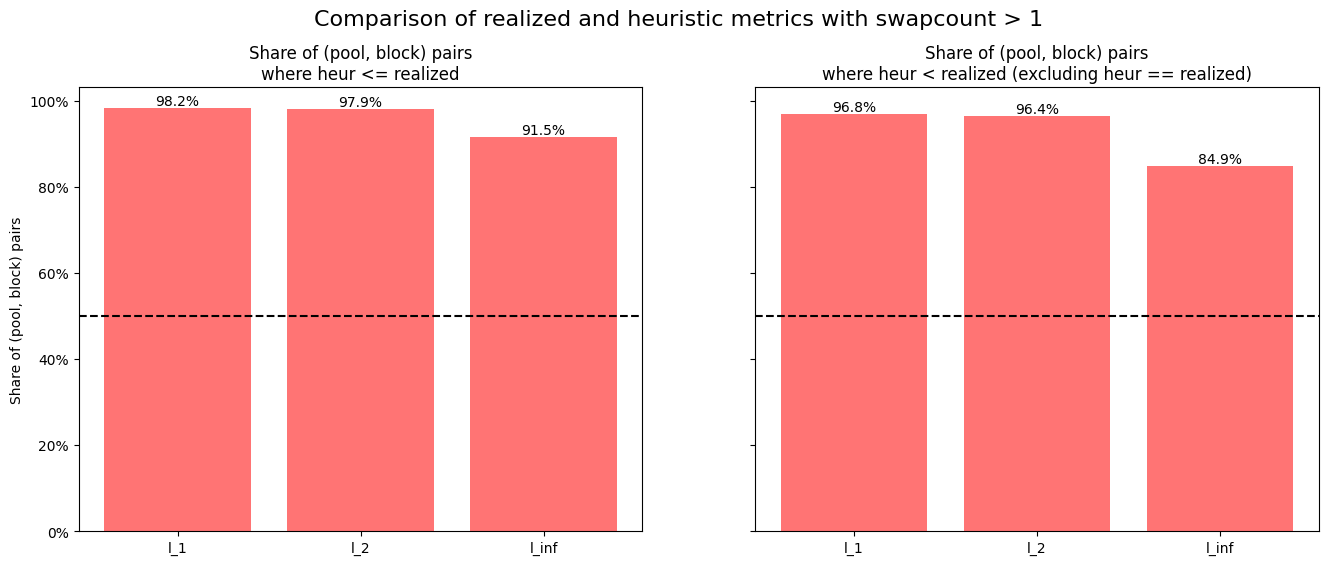

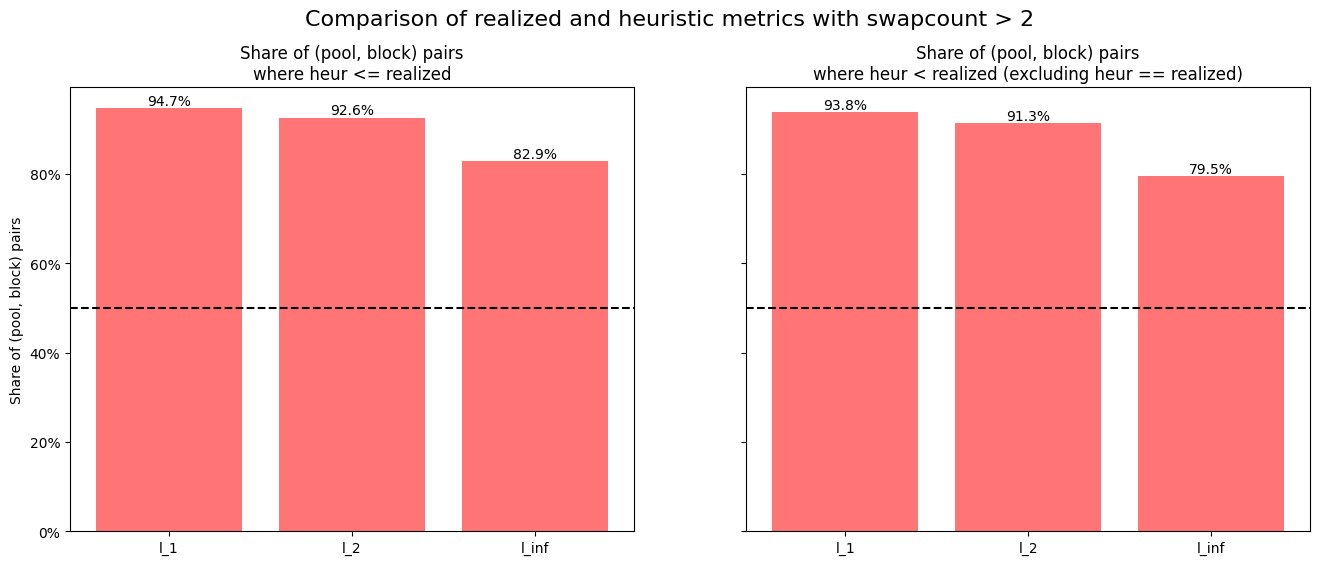

In [30]:
def plot_metric_comparison(df, ax1, ax2):
    differences = df[realized_metrics].values - df[volume_metrics].values

    diff_df = pd.DataFrame(differences, columns=["l_1", "l_2", "l_inf"])

    diff_df_no_zeros = diff_df[(diff_df != 0).all(1)]

    # Plot the rate each metric is positive

    bars = ax1.bar(x=diff_df.columns, height=(diff_df >= 0).mean(), color=bar_cols[1])

    ax1.set_title("Share of (pool, block) pairs\nwhere heur <= realized")
    ax1.set_ylabel("Share of (pool, block) pairs")
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

    # Add horizontal line at 50%
    ax1.axhline(0.5, color="black", linestyle="--")

    bars = ax2.bar(
        x=diff_df_no_zeros.columns,
        height=(diff_df_no_zeros >= 0).mean(),
        color=bar_cols[1],
    )

    ax2.set_title("Share of (pool, block) pairs\nwhere heur < realized (excluding heur == realized)")
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, "{:.1%}".format(height), ha="center", va="bottom")

    # Add horizontal line at 50%
    ax2.axhline(0.5, color="black", linestyle="--")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle("Comparison of realized and heuristic metrics with swapcount > 1", fontsize=16)
plot_metric_comparison(df_metric, ax1, ax2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle("Comparison of realized and heuristic metrics with swapcount > 2", fontsize=16)
plot_metric_comparison(df_metric_2, ax1, ax2)

### Heuristic $\widehat{T}^*$ vs. $T^*$

The below shows that in 85 % of cases where the realized order is worse than the optimal order, the heuristic is equal to the optimal order.


85.6% of (pool, block) pairs have heur == T*, mean heur / T* = 1.06
87.3% of (pool, block) pairs have heur == T*, mean heur / T* = 1.04
70.7% of (pool, block) pairs have heur == T*, mean heur / T* = 1.03


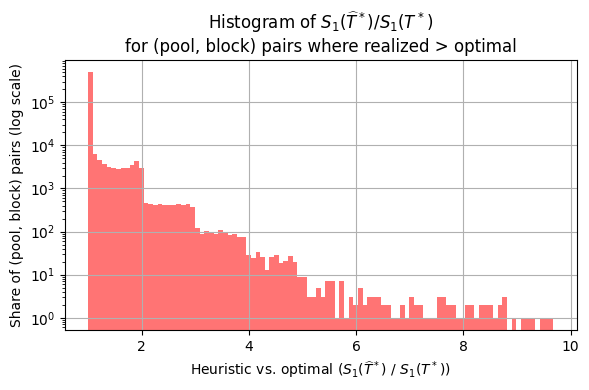

In [31]:
df1 = df_metric[(df_metric.tstar_l1 != 0) & (df_metric.realized_l1 != df_metric.tstar_l1)]

heur_rel = pd.DataFrame(df1[volume_metrics].values / df1[tstar_metrics].values, columns=["l_1", "l_2", "l_inf"])
heur_rel = heur_rel[heur_rel.l_1 < 1e1]

print(
    f"{(heur_rel.l_1 == 1).mean():.1%} of (pool, block) pairs have heur == T*, mean heur / T* = {heur_rel.l_1.mean():.2f}"
)
print(
    f"{(heur_rel.l_2 == 1).mean():.1%} of (pool, block) pairs have heur == T*, mean heur / T* = {heur_rel.l_2.mean():.2f}"
)
print(
    f"{(heur_rel.l_inf == 1).mean():.1%} of (pool, block) pairs have heur == T*, mean heur / T* = {heur_rel.l_inf.mean():.2f}"
)

fig, ax = plt.subplots(figsize=(6, 4))
heur_rel.l_1.hist(bins=100, log=True, figsize=(6, 4), color=bar_cols[1], grid=True, ax=ax)
ax.set_title("Histogram of $S_1(\widehat{T}^*) / S_1(T^*)$\nfor (pool, block) pairs where realized > optimal")
ax.set_xlabel("Heuristic vs. optimal ($S_1(\widehat{T}^*)$ / $S_1(T^*)$)")
ax.set_ylabel("Share of (pool, block) pairs (log scale)")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "heuristic" / "histogram.pdf"))

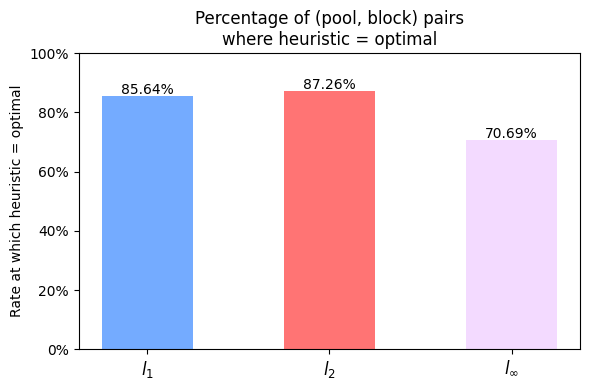

In [33]:
# Metrics
metrics = ["l_1", "l_2", "l_\infty"]

# Percentage of (pool, block) pairs where heur == T*
percentages = [
    (heur_rel.l_1 == 1).mean(),
    (heur_rel.l_2 == 1).mean(),
    (heur_rel.l_inf == 1).mean(),
]


fig, ax = plt.subplots(figsize=(6, 4))

# Bar width
width = 0.5
x = np.arange(len(metrics))  # Use the number of metrics as x-values

# Plot the percentages (first group)
for i, (percentage, metric, col) in enumerate(zip(percentages, metrics, bar_cols)):
    bar = ax.bar(x[i], percentage, width=width, color=col)  # Align bars with x[i]
    ax.text(x[i], bar[0].get_height() + 0.005, f"{percentage:.2%}", ha="center")

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_ylim(0, 1)
# ax.legend(frameon=False, ncol=3, fontsize=12)
ax.set_ylabel("Rate at which heuristic = optimal")

# Set x-tick labels with metric names
ax.set_xticks(x)
ax.set_xticklabels([f"${metric}$" for metric in metrics], fontsize=12)

ax.set_title("Percentage of (pool, block) pairs\nwhere heuristic = optimal")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "heuristic" / "percent_optimal.pdf"))

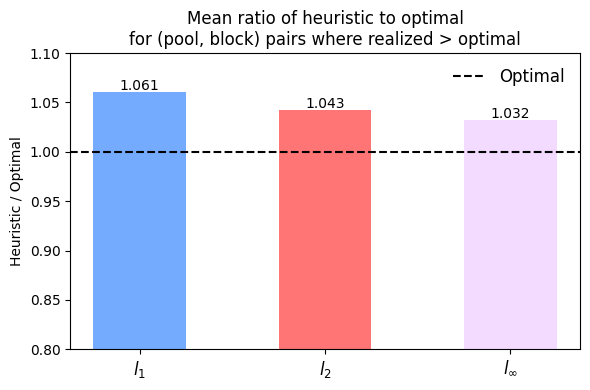

In [34]:
# Mean ratio heur / T*
mean_ratios = [heur_rel.l_1.mean(), heur_rel.l_2.mean(), heur_rel.l_inf.mean()]

fig, ax = plt.subplots(figsize=(6, 4))
# Plot the mean ratios (second group)
for i, (mean_ratio, metric, col) in enumerate(zip(mean_ratios, metrics, bar_cols)):
    bar = ax.bar(x[i], mean_ratio, width=width, color=col)  # Align bars with x[i]
    ax.text(x[i], bar[0].get_height() + 0.002, f"{mean_ratio:.3f}", ha="center")

ax.set_ylim(0.8, 1.1)
ax.axhline(1, color="black", linestyle="--", xmin=0, xmax=1, label="Optimal")  # Add horizontal line at 1 (optimal)

# Add labels and title
# ax.set_title('Comparison of heuristic and optimal metrics')
ax.set_ylabel("Heuristic / Optimal")
# ax.set_xticks(x)
# ax.set_xticklabels(['Percentage', 'Mean Ratio'])
ax.legend(frameon=False, ncol=3, fontsize=12)

# Set x-tick labels with metric names
ax.set_xticks(x)
ax.set_xticklabels([f"${metric}$" for metric in metrics], fontsize=12)

ax.set_title("Mean ratio of heuristic to optimal\nfor (pool, block) pairs where realized > optimal")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "heuristic" / "mean_ratio.pdf"))

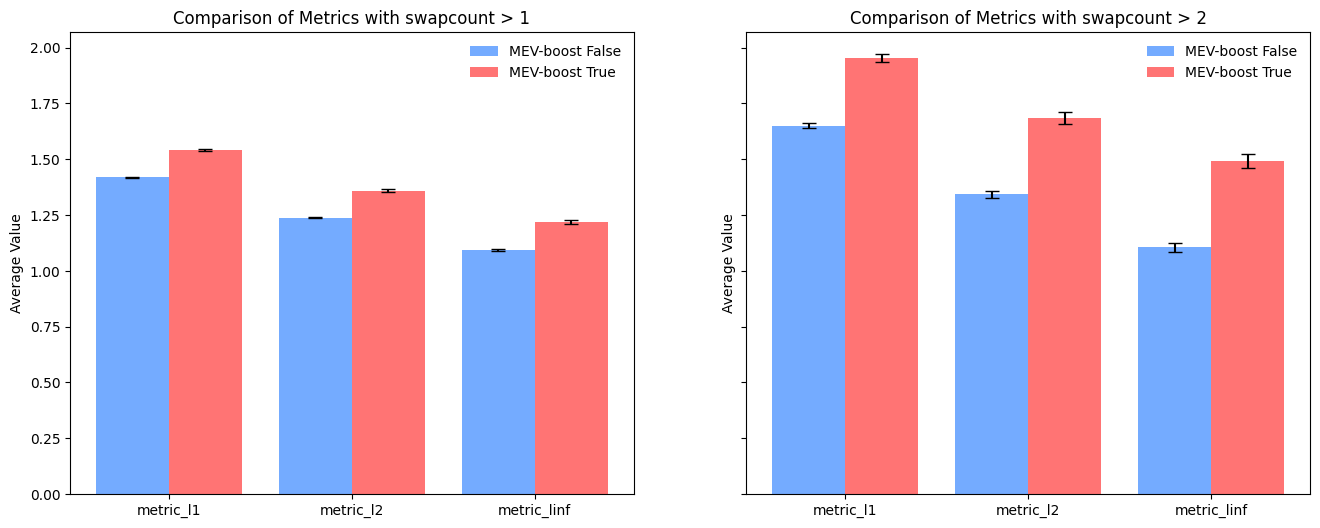

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)


def plot_between_group_comp(df, ax, title=None):
    # Split the DataFrame into two groups based on MEV-boost (true/false)
    grouped = df.groupby("mev_boost")

    # Define the metrics
    metrics = ["metric_l1", "metric_l2", "metric_linf"]

    # Store means and standard errors for both groups
    means = []
    errors = []

    # Calculate the means and standard errors for each metric
    for metric in metrics:
        mean = grouped[metric].mean()
        error = grouped[metric].sem()  # Standard error of the mean
        means.append(mean)
        errors.append(error)

    # Convert to a NumPy array for easy indexing
    means = np.array(means)
    errors = np.array(errors)

    # Plot the means with error bars
    width = 0.4  # Width of the bars
    x = np.arange(len(metrics))

    for i, label in enumerate(["MEV-boost False", "MEV-boost True"]):
        ax.bar(x + i * width, means[:, i], width=width, yerr=errors[:, i], capsize=5, label=label, color=bar_cols[i])

    ax.set_ylabel("Average Value")
    ax.set_title(title)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(metrics)
    ax.legend(frameon=False)


plot_between_group_comp(df_metric, ax1, title="Comparison of Metrics with swapcount > 1")
plot_between_group_comp(df_metric_2, ax2, title="Comparison of Metrics with swapcount > 2")

## Application of the Metric

### Between-group comparison


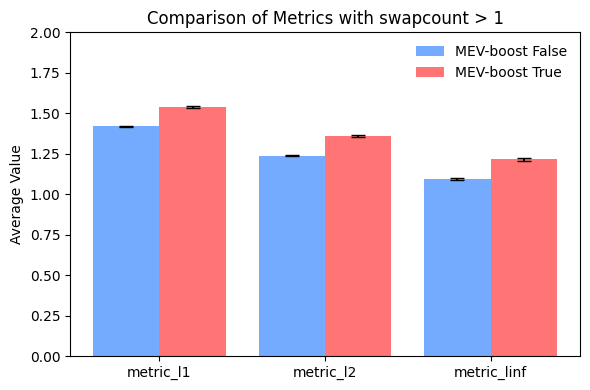

In [36]:
# Plotting for the paper
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim(0, 2)
plot_between_group_comp(df_metric, ax, title="Comparison of Metrics with swapcount > 1")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "empirical" / "mev_boost_vs_vanilla>1.pdf"))

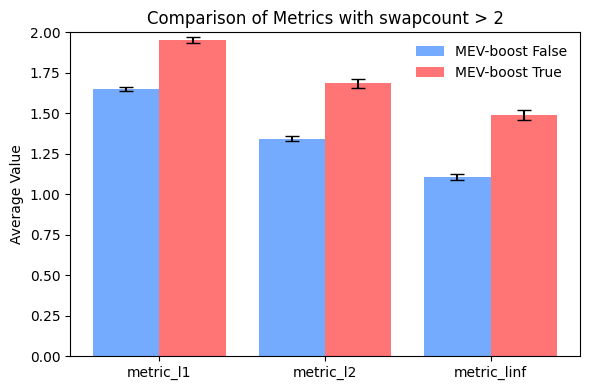

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim(0, 2)
plot_between_group_comp(df_metric_2, ax, title="Comparison of Metrics with swapcount > 2")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "empirical" / "mev_boost_vs_vanilla>2.pdf"))

### Within MEV-boost group comparison


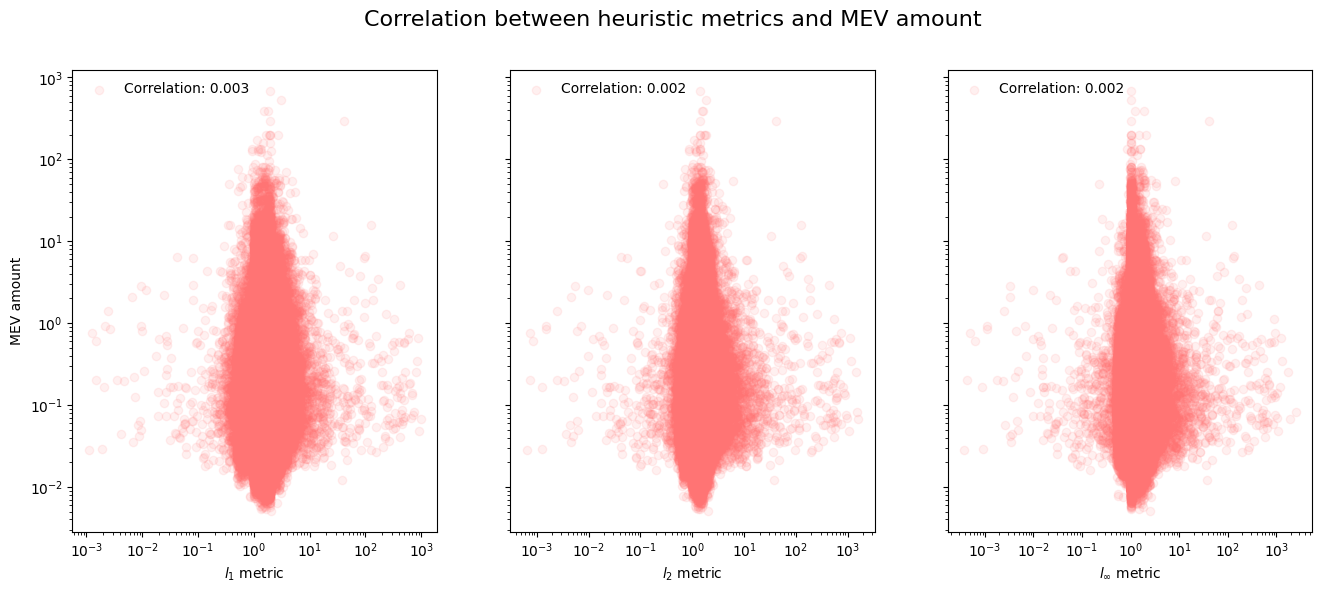

In [38]:
def plot_correlations(df, ax1, ax2, ax3):
    # df_metric_mev = df_metric_mev[(df_metric_mev.metric_l1 < 100) & (df_metric_mev.mev_boost_amount < 100)]

    l1 = df_metric_mev.metric_l1
    l2 = df_metric_mev.metric_l2
    linf = df_metric_mev.metric_linf
    mev_amount = df_metric_mev.mev_boost_amount

    # Calculate the correlation between the metrics and MEV amount
    corr_l1 = l1.corr(mev_amount)
    corr_l2 = l2.corr(mev_amount)
    corr_linf = linf.corr(mev_amount)

    ax1.scatter(l1, mev_amount, alpha=0.1, color=bar_cols[1], label=f"Correlation: {corr_l1:.3f}")
    ax1.loglog()
    ax1.set_xlabel("$l_1$ metric")
    ax1.set_ylabel("MEV amount")
    ax1.legend(frameon=False)

    ax2.scatter(l2, mev_amount, alpha=0.1, color=bar_cols[1], label=f"Correlation: {corr_l2:.3f}")
    ax2.loglog()
    ax2.set_xlabel("$l_2$ metric")
    ax2.legend(frameon=False)

    ax3.scatter(linf, mev_amount, alpha=0.1, color=bar_cols[1], label=f"Correlation: {corr_linf:.3f}")
    ax3.loglog()
    ax3.set_xlabel("$l_{\infty}$ metric")
    ax3.legend(frameon=False)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
df_metric_mev = df_metric[df_metric.mev_boost == True]
df_metric_mev = df_metric_mev[df_metric_mev.metric_l1 != 1]

fig.suptitle("Correlation between heuristic metrics and MEV amount", fontsize=16)
plot_correlations(df_metric_mev, ax1, ax2, ax3)

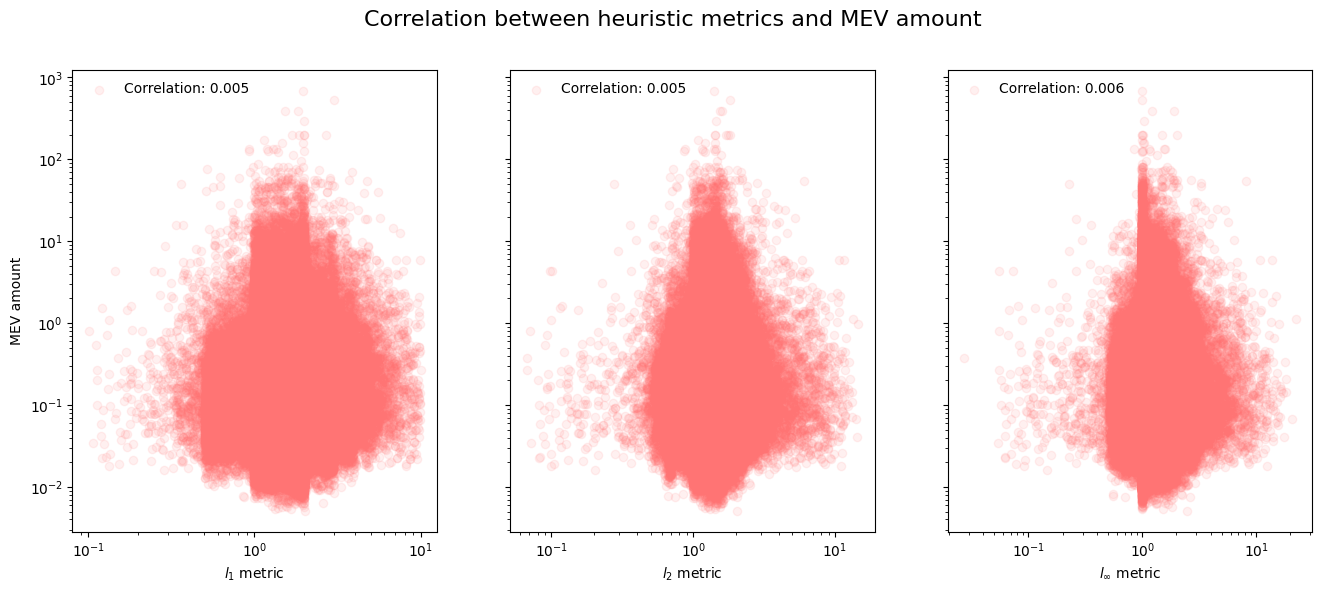

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
df_metric_mev = df_metric[df_metric.mev_boost == True]
df_metric_mev = df_metric_mev[df_metric_mev.metric_l1 != 1]
df_metric_mev = df_metric_mev[(df_metric_mev.metric_l1 < 1e1) & (df_metric_mev.metric_l1 > 1e-1)]

fig.suptitle("Correlation between heuristic metrics and MEV amount", fontsize=16)
plot_correlations(df_metric_mev, ax1, ax2, ax3)

### Plot some example price trajectories


Pool: 0x35e462cd5adde02da41f7f49e156b91b62f9373f, Block: 17247661, Swapcount: 6
Pool: 0xac63436b092b944cadea9243f9aff315421d4fee, Block: 17380874, Swapcount: 11
Pool: 0x60594a405d53811d3bc4766596efd80fd545a270, Block: 15574956, Swapcount: 4
Pool: 0xd8de6af55f618a7bc69835d55ddc6582220c36c0, Block: 16528093, Swapcount: 5
Pool: 0x6f41040b9e098c2ac4b88e27b50d4e9ab486781b, Block: 16629365, Swapcount: 5


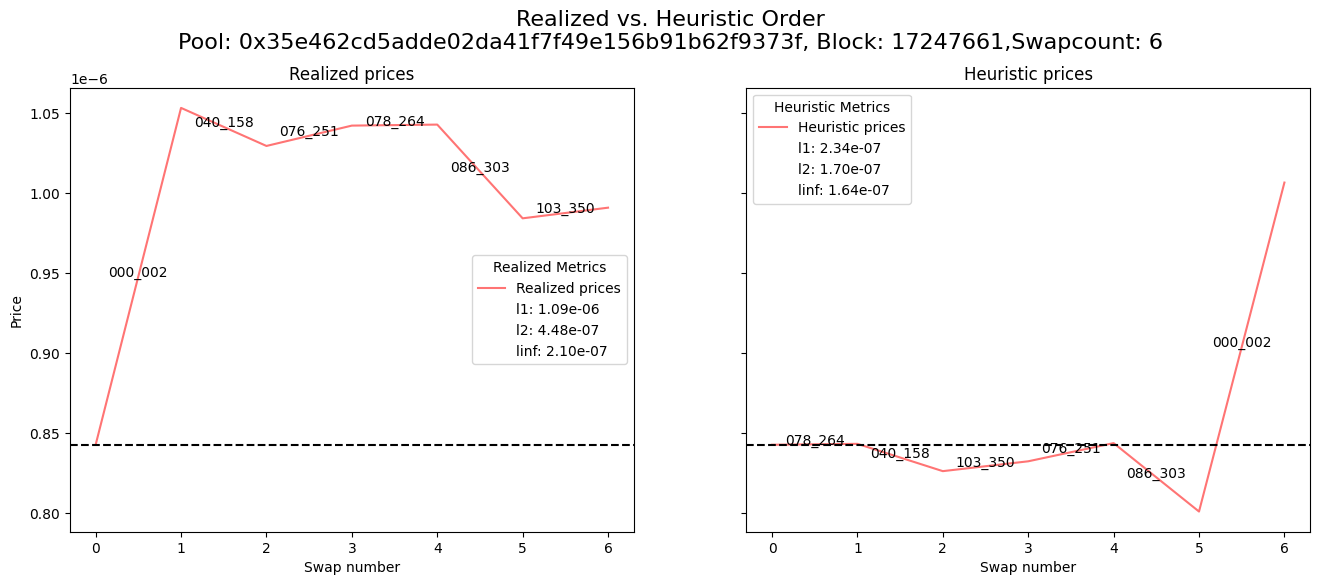

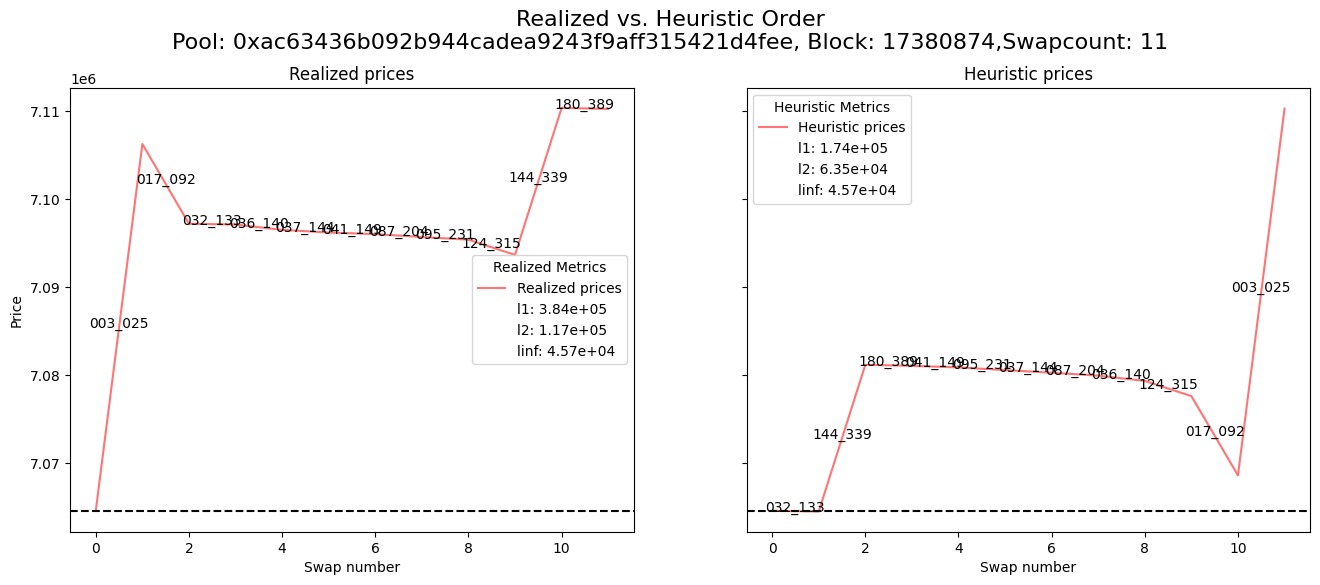

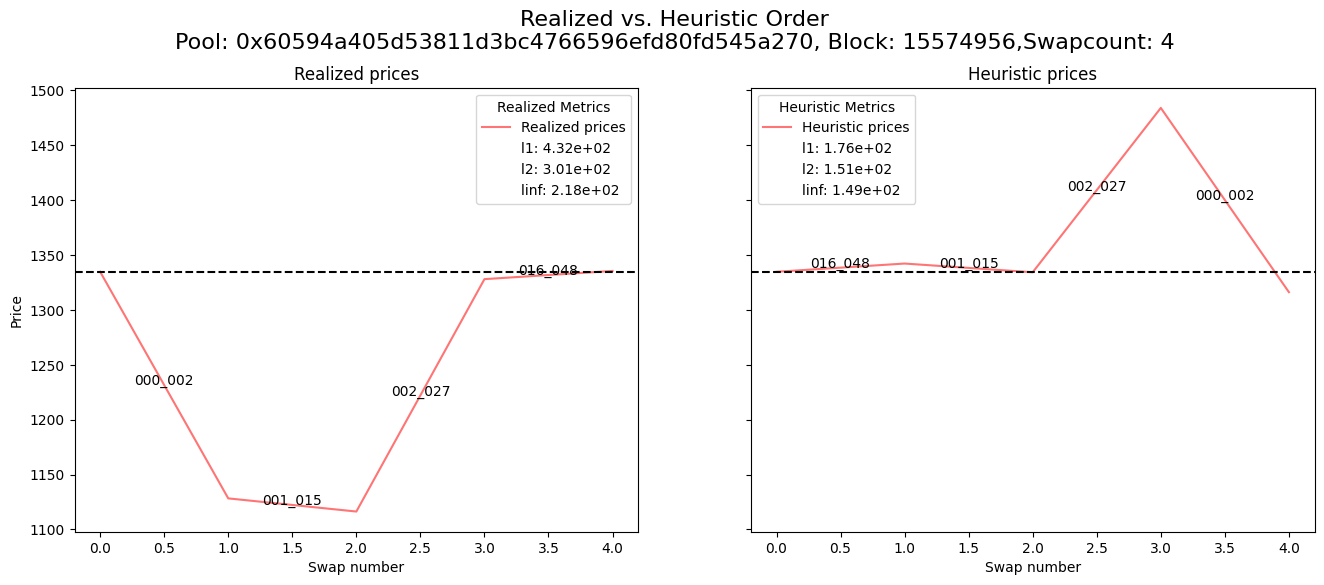

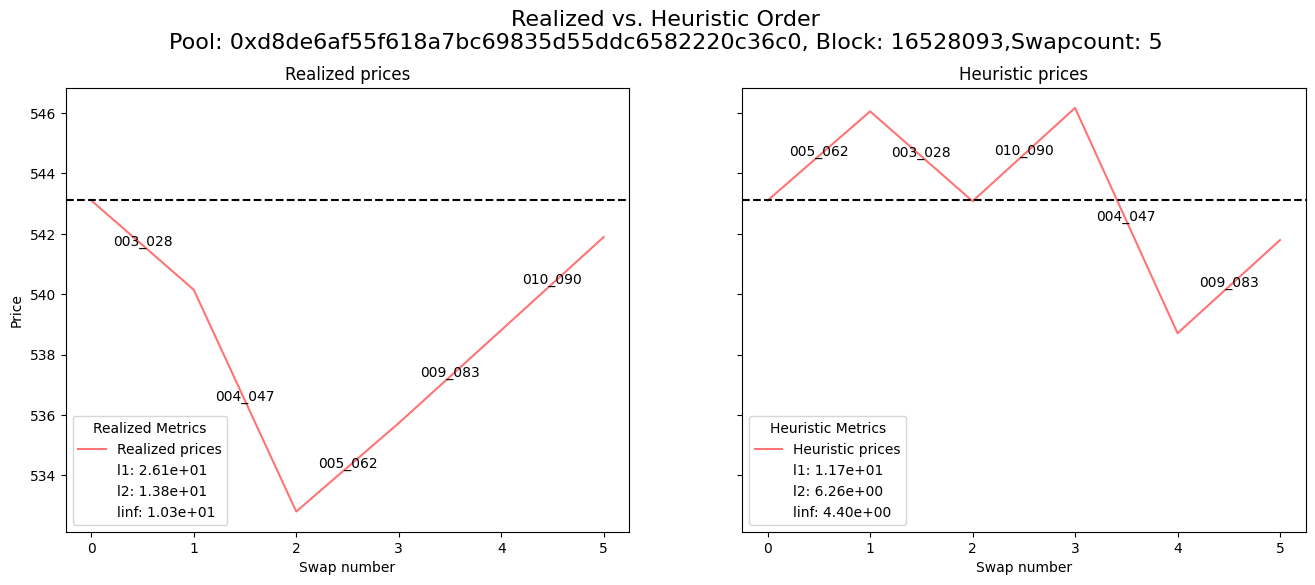

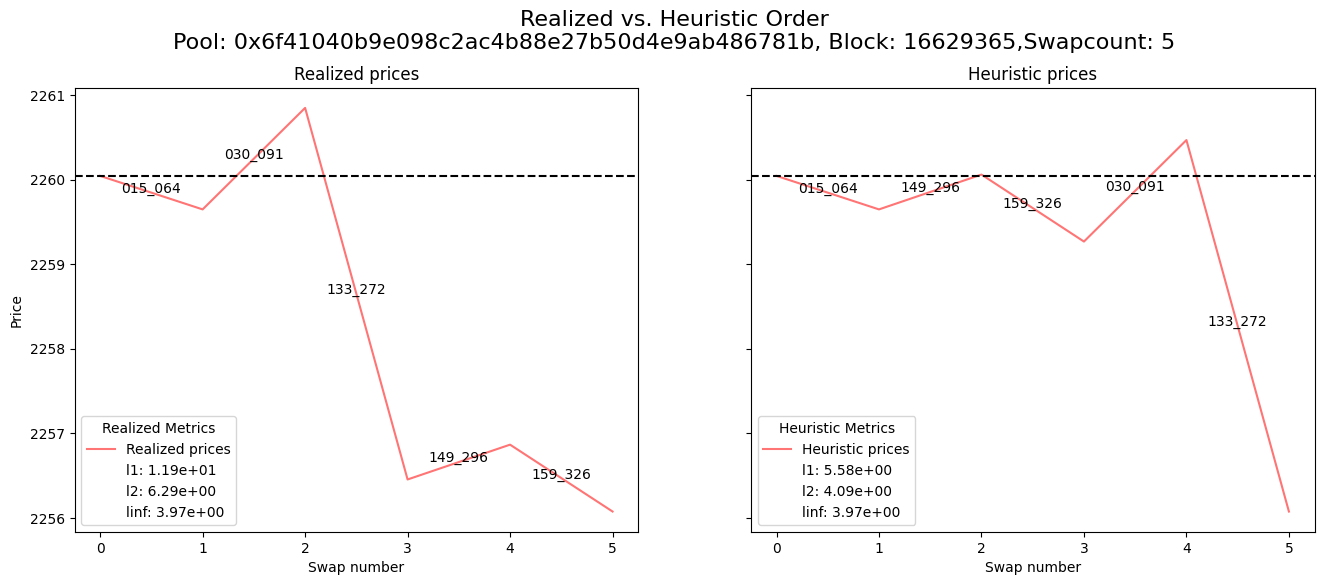

In [51]:
bar_col = bar_cols[1]

for i, row in df_metric[(df_metric.n_buys > 1) & (df_metric.n_sells > 1)].sample(n=5).iterrows():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    realized_prices = [row.baseline_price] + row.realized_prices
    heuristic_prices = [row.baseline_price] + row.volume_heur_prices
    ax1.plot(realized_prices, label="Realized prices", color=bar_col)
    ax2.plot(heuristic_prices, label="Heuristic prices", color=bar_col)

    # Add baseline price
    ax1.axhline(row.baseline_price, color="black", linestyle="--", label="Baseline price")
    ax2.axhline(row.baseline_price, color="black", linestyle="--", label="Baseline price")

    ax1.set_title("Realized prices")
    ax2.set_title("Heuristic prices")

    ax1.set_ylabel("Price")
    ax1.set_xlabel("Swap number")
    ax2.set_xlabel("Swap number")

    # Create custom legend for ax1 (Realized Metrics)
    realized_legend_elements = [
        Line2D([0], [0], label="Realized prices", color=bar_col),
        Line2D([0], [0], color="white", label=f"l1: {row.realized_l1:.2e}"),
        Line2D([0], [0], color="white", label=f"l2: {row.realized_l2:.2e}"),
        Line2D([0], [0], color="white", label=f"linf: {row.realized_linf:.2e}"),
    ]
    ax1.legend(handles=realized_legend_elements, title="Realized Metrics")

    # Create custom legend for ax2 (Heuristic Metrics)
    heuristic_legend_elements = [
        Line2D([0], [0], label="Heuristic prices", color=bar_col),
        Line2D([0], [0], color="white", label=f"l1: {row.volume_heur_l1:.2e}"),
        Line2D([0], [0], color="white", label=f"l2: {row.volume_heur_l2:.2e}"),
        Line2D([0], [0], color="white", label=f"linf: {row.volume_heur_linf:.2e}"),
    ]
    ax2.legend(handles=heuristic_legend_elements, title="Heuristic Metrics")

    # Add swap labels for realized prices
    swap_labels = row.realized_order
    for j in range(len(swap_labels)):
        ax1.text(j + 0.5, (realized_prices[j] + realized_prices[j + 1]) / 2, swap_labels[j], ha="center")

    # Add swap labels for heuristic prices
    swap_labels = row.volume_heur_order
    for j in range(len(swap_labels)):
        ax2.text(j + 0.5, (heuristic_prices[j] + heuristic_prices[j + 1]) / 2, swap_labels[j], ha="center")

    fig.subplots_adjust(top=0.85)
    fig.suptitle(
        f"Realized vs. Heuristic Order\nPool: {row.pool_address}, Block: {row.block_number},Swapcount: {row.num_transactions}",
        fontsize=16,
    )
    print(f"Pool: {row.pool_address}, Block: {row.block_number}, Swapcount: {row.num_transactions}")

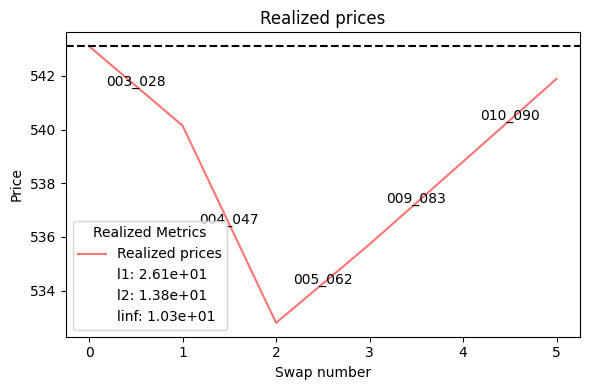

In [52]:
# Create separate plots for:
# Pool: 0x4c1c69be20fadee2f3e7883f1c618be2df828e9c, Block: 17275081,Swapcount: 5
# Pool: 0xd8de6af55f618a7bc69835d55ddc6582220c36c0, Block: 16528093, Swapcount: 5


swap = df_metric[
    (df_metric.pool_address == "0xd8de6af55f618a7bc69835d55ddc6582220c36c0") & (df_metric.block_number == 16528093)
].iloc[0]
fig, ax = plt.subplots(figsize=(6, 4))

realized_prices = [swap.baseline_price] + swap.realized_prices
ax.plot(realized_prices, label="Realized prices", color=bar_col)

# Add baseline price
ax.axhline(swap.baseline_price, color="black", linestyle="--", label="Baseline price")

ax.set_title("Realized prices")

ax.set_ylabel("Price")
ax.set_xlabel("Swap number")

# Create custom legend for ax (Realized Metrics)
realized_legend_elements = [
    Line2D([0], [0], label="Realized prices", color=bar_col),
    Line2D([0], [0], color="white", label=f"l1: {swap.realized_l1:.2e}"),
    Line2D([0], [0], color="white", label=f"l2: {swap.realized_l2:.2e}"),
    Line2D([0], [0], color="white", label=f"linf: {swap.realized_linf:.2e}"),
]
ax.legend(handles=realized_legend_elements, title="Realized Metrics")


# Add swap labels for realized prices
swap_labels = swap.realized_order
for j in range(len(swap_labels)):
    ax.text(j + 0.5, (realized_prices[j] + realized_prices[j + 1]) / 2, swap_labels[j], ha="center")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "heuristic" / "realized_order.pdf"))

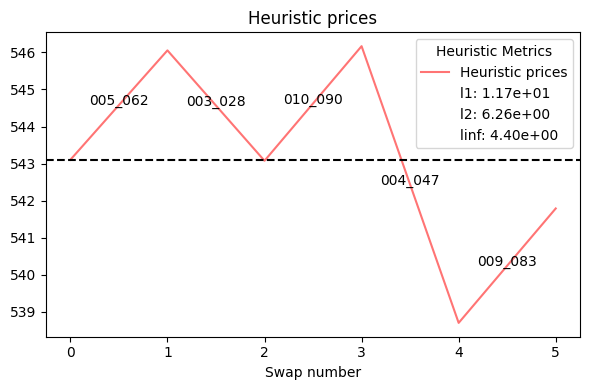

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))

heuristic_prices = [swap.baseline_price] + swap.volume_heur_prices

ax.plot(heuristic_prices, label="Heuristic prices", color=bar_col)
ax.axhline(swap.baseline_price, color="black", linestyle="--", label="Baseline price")

ax.set_title("Heuristic prices")
ax.set_xlabel("Swap number")

# Create custom legend for ax (Heuristic Metrics)
heuristic_legend_elements = [
    Line2D([0], [0], label="Heuristic prices", color=bar_col),
    Line2D([0], [0], color="white", label=f"l1: {swap.volume_heur_l1:.2e}"),
    Line2D([0], [0], color="white", label=f"l2: {swap.volume_heur_l2:.2e}"),
    Line2D([0], [0], color="white", label=f"linf: {swap.volume_heur_linf:.2e}"),
]
ax.legend(handles=heuristic_legend_elements, title="Heuristic Metrics")

# Add swap labels for heuristic prices
swap_labels = swap.volume_heur_order
for j in range(len(swap_labels)):
    ax.text(j + 0.5, (heuristic_prices[j] + heuristic_prices[j + 1]) / 2, swap_labels[j], ha="center")

# Save plot
fig.tight_layout()
fig.savefig(str(plot_base_path / "heuristic" / "heuristic_order.pdf"))